Measuring `CATE` for [Crépon et al., (2015)](https://www.aeaweb.org/articles?id=10.1257/app.20130535)

In [49]:
import pandas as pd
from dowhy import CausalModel
from IPython.display import Image, display

# read Stata .dta file 
df = pd.read_stata("data/data_rep.dta")

# set variables 
treatment = ['treatment']
outcome = ['loansamt_total']
covariates = ["members_resid_bl", "nadults_resid_bl", "head_age_bl", "act_livestock_bl", "act_business_bl",
              "borrowed_total_bl", "members_resid_d_bl", "nadults_resid_d_bl", "head_age_d_bl",
              "act_livestock_d_bl", "act_business_d_bl", "borrowed_total_d_bl", "ccm_resp_activ",
              "other_resp_activ", "ccm_resp_activ_d", "other_resp_activ_d", "head_educ_1", "nmember_age6_16"]

# build causal graph with dowhy 
model = CausalModel(
    data=df,
    treatment=treatment, 
    outcome=outcome, 
    common_causes=covariates, 
    instruments=None, 
    effect_modifiers=None)


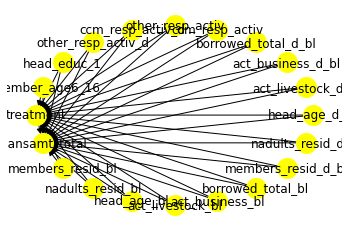

In [51]:
model.view_model()


In [13]:
from sklearn.model_selection import train_test_split
# drop missing data 
all_variables = treatment+outcome+covariates
df = df.dropna(axis=0, subset=all_variables)

# split data into train and test sets 
train, test = train_test_split(df, test_size=0.2)

# set variables for causal forest Y=outcome, T=treatment, X=covariates, W=effect_modifiers 
Y = train[outcome]
T = train[treatment]
X = train[covariates]
W = None
X_test = test[covariates]

In [14]:
from econml.dml import CausalForestDML
from sklearn.linear_model import MultiTaskLassoCV

# set parameters for causal forest 
causal_forest = CausalForestDML(criterion='het', 
                                n_estimators=10000,       
                                min_samples_leaf=10, 
                                max_depth=None, 
                                max_samples=0.5,
                                discrete_treatment=False,
                                honest=True,
                                inference=True,
                                cv=10,
                                model_t=MultiTaskLassoCV(), 
                                model_y=MultiTaskLassoCV(),
                                )
                      
# fit train data to causal forest model 
causal_forest.fit(Y, T, X=X, W=W)
# estimate the CATE with the test set 
causal_forest.const_marginal_ate(X_test)

array([[1029.24894238]])

In [16]:
# code adapted from https://github.com/microsoft/EconML
import shap
from econml.dml import CausalForestDML

# fit causal forest with default parameters 
causal_forest = CausalForestDML()
causal_forest.fit(Y, T, X=X, W=W)

# calculate shap values of causal forest model 
shap_values = causal_forest.shap_values(X)


 99%|===================| 4365/4406 [00:42<00:00]        

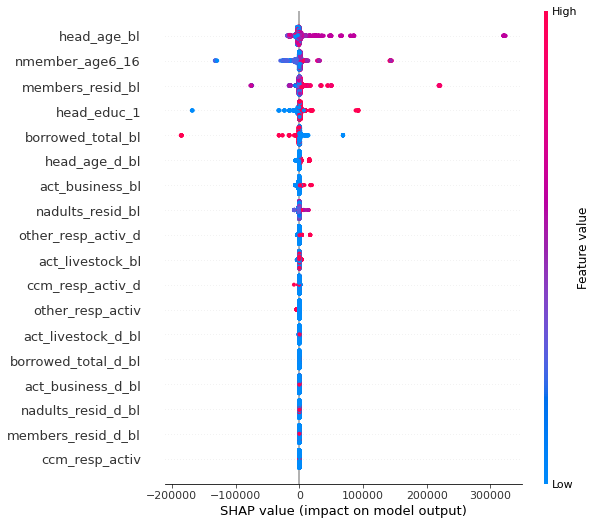

In [26]:
# plot shap values 
shap.summary_plot(shap_values['loansamt_total']['treatment'])

In [17]:
# use causal forest model to estimate treatment effects  
treatment_effects = causal_forest.effect(X)
# calculate lower bound and upper bound confidence intervals 
lb, ub = causal_forest.effect_interval(X, alpha=0.05)

# convert arrays to pandas dataframes for plotting
te_df = pd.DataFrame(treatment_effects, columns=['cate'])
lb_df = pd.DataFrame(lb, columns=['lb'])
ub_df = pd.DataFrame(ub, columns=['ub'])

# merge dataframes and sort 
df = te_df.merge(lb_df, left_on=te_df.index, right_on=lb_df.index, how='left')
df.drop(columns=['key_0'], inplace=True)
df = df.merge(ub_df, left_on=df.index, right_on=ub_df.index, how='left')
df.drop(columns=['key_0'], inplace=True)
df.sort_values('cate', inplace=True, ascending=True)
df.reset_index(inplace=True, drop=True)

# calculate rolling mean
z = df.rolling(window=30, center=True).mean()

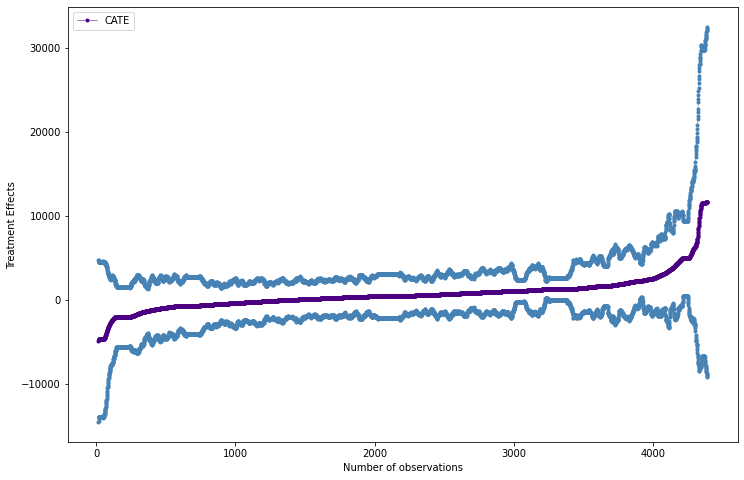

In [18]:
import matplotlib.pyplot as plt

# set plot size
fig, ax = plt.subplots(figsize=(12, 8))
# plot lines for treatment effects and confidence intervals
ax.plot(z['cate'],
        marker='.', linestyle='-', linewidth=0.5, label='CATE', color='indigo')
ax.plot(z['lb'],
        marker='.', linestyle='-', linewidth=0.5, color='steelblue')
ax.plot(z['ub'],
        marker='.', linestyle='-', linewidth=0.5, color='steelblue')
# label axes and create legend
ax.set_ylabel('Treatment Effects')
ax.set_xlabel('Number of observations')
ax.legend()